## Training Feed Forward Neural Network 
#### BackPropagation and Gradient Descent vs Genetic Algorithm


The goal of this project is to asses the use of genetic algorithm in training neural network and updating weights vs the use
of backpropagation algorithm.

In [1]:
import matplotlib.pyplot as plt
from load_data import load_dataset
import backprop_functions as bp
from PIL import Image
import seaborn as sns
import numpy as np
import h5py
import scipy
import random
%matplotlib inline

In [2]:
# import genetic algorithms library
from deap import base
from deap import creator
from deap import tools
import elitism
from random import randint

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


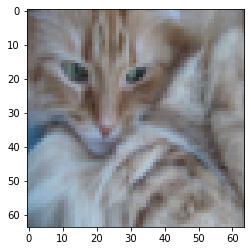

In [4]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
# Raw Train and Test Shapes 
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# Standarize the inputs
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


### BackPropagation 

This BackPropagation part is taken from DeepLearning.ai Course

In [7]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
        
    # initialize parameters with zeros 
    w, b = bp.initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = bp.optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = bp.predict(w, b, X_test)
    Y_prediction_train = bp.predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [8]:
result = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


### Genetic Algorithm 

In this part I am going to train a one layer neural network using genetic algorithm. 
In other words, finding the optimal set of values "Weight Vector" that will minimize the cost function simply through iteration and Fitness values.

- The chromosome representation of the GA will the the weight vector itself of the Neural Network.
- We will start with a population of chromosome (potential solutions) of POPULATION_SIZE.
- Apply a selection process "Tournament selection" to choose the best parents of the next generation.
- Apply a crossover process "SimulatedBinaryBounded" within boundaries BOUND_LOW, BOUND_UP
- Apply a mutation process "mutPolynomialBounded" within boundaries BOUND_LOW, BOUND_UP
- Use elitism to pass the x best solution fom generation G to G+1 with no modification.
- Repeat the process until a stopping condition is reached : here is MAX_GENERATIONS.

In [8]:
# function that create one individual using random real values between low and up
def randomFloat(low , up):
    return [random.uniform(l, u) for l, u in zip([low] * (DIMENSIONS+1), [up] * (DIMENSIONS+1))]

# Fitness function : score that will let the GA knows wich solution to choose to be the parents of the next generation
def cross_entropy_loss(individual, X_train=train_set_x, Y_train=train_set_y) :
    
    eps = 1e-5
    
    m = X_train.shape[1]
    w = np.array(individual[:-1]) 
    b = individual[-1]
    A = bp.sigmoid(np.dot(w.T,X_train)+b)
    
    cost = round(-(1/m) * np.sum(Y_train*np.log(A+eps)+(1-Y_train)*np.log(1-A+eps)),3) ,
    
    return cost

In [59]:
# Parameters of the Genetic Algorithms
DIMENSIONS = train_set_x.shape[0] # Length of chromosome thar reprensent the weights
BOUND_LOW, BOUND_UP = -0.1, 0.1 # Boundaries of weight values
POPULATION_SIZE = 100 # Population size
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.3   # probability for mutating an individual
MAX_GENERATIONS = 100 # max generations to ierate
HALL_OF_FAME_SIZE = 20 # Number of individuals to pass from G to G+1 without crossover nor mutation 
CROWDING_FACTOR = 10.0  # crowding factor for crossover and mutation

In [60]:
random.seed(42)

# Definition of algorithms to compute the GA pipeline using DEAP
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
toolbox.register("evaluate", cross_entropy_loss)
toolbox.register("select", tools.selTournament,tournsize = 4)
toolbox.register("mate",  tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=10.0/DIMENSIONS)

In [31]:
def model(toolbox, X_train, Y_train, X_test, Y_test):
    """
    Builds the logistic regression model by calling the function you've implemented previously but training with GA algorithm
        
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    toolbox -- GA class that saves optimisation parameters and algorithms to be used later
    
    Returns:
    d -- dictionary containing information about the model.
    """    
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    
    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)
       
    # Infos on best solution found:
    best = hof.items[0]
    
    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    plt.show()
  
    # Retrieve parameters w and b from dictionary "parameters"
    w = np.array(best[:-1])
    b = best[-1]
    
    # Predict test/train 
    Y_prediction_test = bp.predict(w, b, X_test)
    Y_prediction_train = bp.predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": best.fitness.values[0],
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b}
    
    return d

gen	nevals	min  	avg    
0  	100   	2.241	3.94754
1  	58    	2.211	2.99987
2  	65    	1.789	2.83352
3  	55    	1.789	2.60072
4  	55    	1.602	2.42983
5  	62    	1.602	2.33102
6  	52    	1.602	2.37952
7  	57    	1.539	2.04481
8  	51    	1.539	2.04603
9  	58    	1.539	2.12531
10 	61    	1.403	1.9389 
11 	60    	1.403	1.95289
12 	51    	1.403	1.83036
13 	61    	1.384	1.86647
14 	58    	1.376	1.56289
15 	55    	1.349	1.4422 
16 	54    	1.344	1.39843
17 	54    	1.344	1.37828
18 	54    	1.336	1.36181
19 	58    	1.329	1.3518 
20 	47    	1.326	1.34517
21 	57    	1.326	1.34066
22 	56    	1.326	1.33443
23 	58    	1.316	1.3306 
24 	56    	1.313	1.32599
25 	50    	1.311	1.32098
26 	58    	1.308	1.31675
27 	57    	1.307	1.31374
28 	54    	1.303	1.31182
29 	53    	1.297	1.30938
30 	50    	1.296	1.30667
31 	52    	1.294	1.30319
32 	54    	1.291	1.29944
33 	56    	1.284	1.29604
34 	56    	1.279	1.29231
35 	51    	1.279	1.28843
36 	56    	1.273	1.28546
37 	61    	1.273	1.28224
38 	52    	1.27 	1.27894


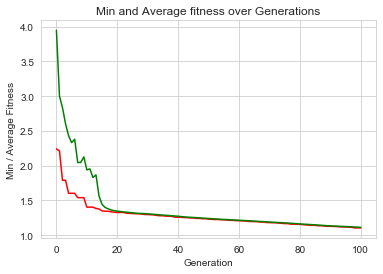

train accuracy: 70.33492822966508 %
test accuracy: 58.0 %


In [33]:
# BOUND_LOW, BOUND_UP = -0.5, 0.5
Result = model(toolbox, train_set_x, train_set_y, test_set_x, test_set_y)


gen	nevals	min  	avg    
0  	100   	0.771	1.46543
1  	58    	0.771	0.9899 
2  	53    	0.722	0.90938
3  	61    	0.706	0.87544
4  	51    	0.706	0.88109
5  	56    	0.675	0.89101
6  	54    	0.643	0.82273
7  	58    	0.643	0.78794
8  	56    	0.643	0.76938
9  	59    	0.643	0.72664
10 	62    	0.612	0.72597
11 	59    	0.612	0.67766
12 	47    	0.593	0.65913
13 	63    	0.593	0.68578
14 	62    	0.593	0.64169
15 	60    	0.589	0.62839
16 	59    	0.577	0.61321
17 	61    	0.568	0.60937
18 	51    	0.568	0.59778
19 	54    	0.563	0.5909 
20 	61    	0.563	0.58798
21 	53    	0.553	0.58162
22 	55    	0.553	0.57064
23 	60    	0.539	0.57775
24 	56    	0.539	0.56588
25 	53    	0.539	0.56069
26 	45    	0.539	0.55624
27 	53    	0.532	0.55899
28 	56    	0.532	0.54795
29 	58    	0.527	0.54504
30 	60    	0.526	0.539  
31 	57    	0.526	0.53629
32 	59    	0.524	0.53528
33 	56    	0.524	0.53071
34 	58    	0.524	0.52796
35 	57    	0.524	0.52631
36 	57    	0.52 	0.526  
37 	61    	0.52 	0.52581
38 	58    	0.52 	0.5235 


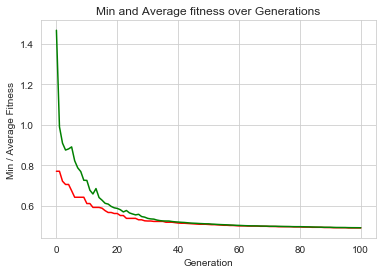

train accuracy: 76.55502392344498 %
test accuracy: 66.0 %


In [47]:
# BOUND_LOW, BOUND_UP = -0.1, 0.1
Result = model(toolbox, train_set_x, train_set_y, test_set_x, test_set_y)

#### Notes
- The bounding range improves the GA choice of values since it is less space to search in.
- From the two graphs we see that the min and average fitness converge early on approximately the Geneartion 40.We conclude that 
  the diversity inside the population disapears quickly.
- To keep the population diversified maybe change : 
    P_MUTATION : increse probability of mutation of individual
    HALL_OF_FAME_SIZE : minimise number of best solutions passed

gen	nevals	min  	avg    
0  	100   	0.771	1.46543
1  	64    	0.763	0.97667
2  	68    	0.714	0.97071
3  	58    	0.714	0.87276
4  	64    	0.691	0.80997
5  	62    	0.689	0.81111
6  	71    	0.669	0.81154
7  	67    	0.669	0.77923
8  	66    	0.627	0.7431 
9  	73    	0.622	0.7175 
10 	64    	0.61 	0.74455
11 	65    	0.61 	0.6892 
12 	68    	0.602	0.66283
13 	69    	0.602	0.62883
14 	68    	0.596	0.6255 
15 	78    	0.596	0.64238
16 	66    	0.583	0.62473
17 	67    	0.581	0.61421
18 	72    	0.562	0.62368
19 	73    	0.557	0.60044
20 	73    	0.557	0.59567
21 	70    	0.554	0.5994 
22 	64    	0.545	0.58325
23 	68    	0.537	0.57174
24 	69    	0.536	0.57145
25 	68    	0.533	0.55576
26 	66    	0.527	0.54757
27 	57    	0.523	0.53688
28 	66    	0.523	0.53582
29 	71    	0.517	0.5304 
30 	67    	0.517	0.5276 
31 	72    	0.51 	0.52447
32 	70    	0.51 	0.52048
33 	60    	0.51 	0.5167 
34 	70    	0.507	0.51428
35 	74    	0.505	0.512  
36 	68    	0.505	0.50968
37 	75    	0.503	0.50794
38 	68    	0.498	0.50746


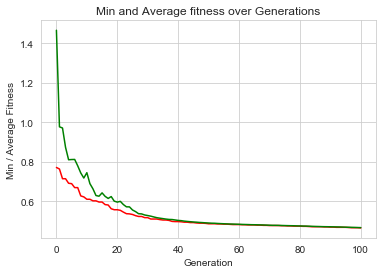

train accuracy: 81.33971291866028 %
test accuracy: 54.0 %


In [50]:
# P_CROSSOVER = 0.6, P_MUTATION = 0.4, HALL_OF_FAME_SIZE = 10 
Result = model(toolbox, train_set_x, train_set_y, test_set_x, test_set_y)

- Achieving more on the training set doesn't necessarly means that it will perform better on the test set

gen	nevals	min  	avg    
0  	100   	0.771	1.46543
1  	68    	0.771	1.02503
2  	66    	0.73 	0.95984
3  	74    	0.73 	0.98152
4  	67    	0.726	0.9101 
5  	64    	0.71 	0.85006
6  	65    	0.679	0.8373 
7  	72    	0.661	0.8359 
8  	68    	0.661	0.79814
9  	71    	0.643	0.76927
10 	68    	0.621	0.78521
11 	69    	0.607	0.73339
12 	70    	0.586	0.73494
13 	68    	0.586	0.70797
14 	73    	0.572	0.67897
15 	72    	0.565	0.68997
16 	71    	0.565	0.6223 
17 	65    	0.552	0.61038
18 	66    	0.552	0.60557
19 	65    	0.547	0.57607
20 	66    	0.542	0.57464
21 	63    	0.534	0.56496
22 	65    	0.53 	0.5597 
23 	69    	0.528	0.55846
24 	67    	0.518	0.54838
25 	66    	0.518	0.54234
26 	69    	0.511	0.54322
27 	60    	0.503	0.53506
28 	65    	0.498	0.52928
29 	66    	0.498	0.52709
30 	73    	0.498	0.52292
31 	62    	0.491	0.51743
32 	71    	0.491	0.51499
33 	64    	0.489	0.50427
34 	74    	0.484	0.50503
35 	70    	0.478	0.50212
36 	65    	0.472	0.49462
37 	75    	0.471	0.49488
38 	69    	0.471	0.48824


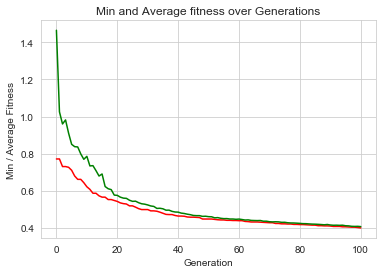

train accuracy: 84.68899521531101 %
test accuracy: 60.0 %


In [55]:
# increse ipnb to 1000 : probability of mutation inside each individual(weights mutations), P_CROSSOVER = 0.8, P_MUTATION = 0.2 
Result = model(toolbox, train_set_x, train_set_y, test_set_x, test_set_y)

#### Notes
- increasing the ipnb keeps the population diversified more since the mean and min not exactly the same through generations.
- The slope of the graph after Geneartion 40 is largely negative due to the mutation aspect.

### Conclusion

- GA is difficult to train , due to the high number of parameters and dimensions of search space, and with no guidance from the outside world but the value of the cost function.

- GA is suited for problems that are too complex to find a mathematical representation or where the loss function contains too many local minimums. In this problem, the backpropagation Algorithm is expected to outperform the GA, since the cost function is differentiable, and the weight update is performed intelligently with the calculation of gradients.

- A more suited approach is to combine both algorithms to benefit from the global optimisation aspect of the GA and prevent Backprop Algorithms in getting stucked in local minimums.
